In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Regularization: constraining parameters by penalty -- prefers smooth poly over wiggly ones

If we are going to fit the data with an expressive model such as **20th order polynomials**, how can we regularize/smooth/restrict the choices of the kinds of 20th order polynomials that we allow in our fits. 

**soft constraint**: for poly $$h_d = \sum_{i=0}^{d} a_ix^i$$
setting Ridge: $$  \sum_{i=0}^{d} a_i^2 < Const=C$$
or setting LASSO: $$\sum_{i=0}^{d} |a_i| < Const=C$$


**we can do this by adding a term to the empirical risk -- idea is coming from lagrange multipliers and the dual problem:

$$Ridge~Regression= \mathcal{R}(h_d) = \sum_{y_i\in\{training\}}(y_i - h_d(x_i))^2 +
\lambda \sum_{i=0}^{d}a_i^2$$

or $$LASSO~Regression = \mathcal{R}(h_d) = \sum_{y_i\in\{training\}}(y_i - h_d(x_i))^2 +
\lambda \sum_{i=0}^{d}|a_i|$$

**This technique is called regularization or shrinkage. When $\lambda$ is tiny, the penalty "does nothing", so we are back to the original ERM and tends to have high variance -- same as when $d$ too big; When $\lambda$ large, the penalty term dominates and we get into the high bias zone -- same as when $d$ too small **

**Thus $\lambda$ acts as a complexity parameter just like $d$ did, with high complexity being $\lambda\rightarrow 0$. **

In [2]:
def plot_functions(est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", alpha=0.4)
    ax.plot(xtest, ytest, 's', label="testing", alpha=0.6)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))

    ## given values of transx
    ## plug into the estimated polynomial to see what values it gets
    ax.plot(transx, est.predict(transX),  '.', \
            label="$\lambda$ = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right',prop={'size': 10})
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="$\lambda$ = %s" % str(alpha))
    ax.set_ylim((1e-2, 1e12))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left',prop={'size': 10})
    

def make_features(train_set, test_set, degrees):
    traintestlist=[]
    for d in degrees:
        traintestdict={}
        traintestdict['train'] = \
            PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        traintestdict['test'] = \
            PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
        traintestlist.append(traintestdict)
    return traintestlist


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("noisysample.csv")

datasize=df.shape[0]
## split dataset as before
itrain,itest = train_test_split(range(datasize),\
                                train_size=24, test_size=6)
## xtrain and test are the same for noisy/noiesless
xtrain = df.x[itrain].values
xtest  = df.x[itest].values

## noiseless
ftrain = df.f[itrain].values
ftest  = df.f[itest].values

## noise
ytrain = df.y[itrain].values
ytest  = df.y[itest].values



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore

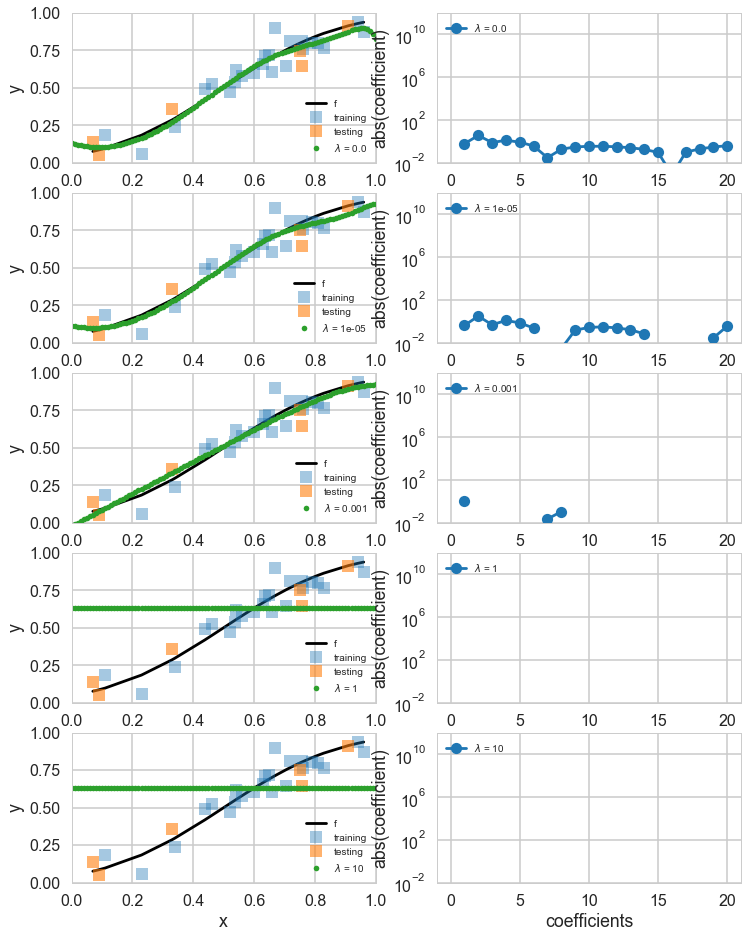

In [11]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

d=20

degrees=range(d+1)
traintestlists=make_features(xtrain, xtest, degrees)

fig, rows = plt.subplots(5, 2, figsize=(12, 16))

alphas = [0.0, 1e-5, 1e-3, 1, 10]
Xtrain = traintestlists[d]['train']
Xtest = traintestlists[d]['test']
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Lasso(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as  $$\lambda ~:~0\rightarrow 10$$
$$overfitting\rightarrow doing~well\rightarrow \text{ develop its own pattern irrespective of data}$$
As $\lambda$ large,  the penalty term dominates the risk.

** use cross-validation find critical $\lambda^*$**

To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:
Here we use Lasso(), ** it sets coef exactly zero**!!


    clf = Lasso()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(clf, param_grid=parameters, cv=4, scoring="mean_squared_error")
    

In [12]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

def cv_Lasso(X, y, n_folds=4):
    clf = Lasso()
    parameters = {"alpha": \
                  [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,\
                      scoring="neg_mean_squared_error")
    gs.fit(X, y)
    return gs

In [14]:
fitmodel = cv_Lasso(Xtrain, ytrain, n_folds=4)
# you can turn off warning!

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/pyth

In [16]:
print("best estimator",fitmodel.best_estimator_ )
print("best params ",fitmodel.best_params_)
print("best score", fitmodel.best_score_)
pd.DataFrame(fitmodel.cv_results_)


best estimator Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
best params  {'alpha': 0.001}
best score -0.008346343187371331


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.004238,0.000574,-0.014613,-0.003863,1e-08,{'alpha': 1e-08},8,-0.012593,-0.002591,-0.032660,-0.004055,-0.007480,-0.004477,-0.005719,-0.004328,0.001287,0.000348,0.010721,0.000750
1,0.003152,0.000462,-0.014609,-0.003865,1e-06,{'alpha': 1e-06},7,-0.012579,-0.002594,-0.032646,-0.004054,-0.007485,-0.004479,-0.005729,-0.004332,0.000833,0.000171,0.010713,0.000749
2,0.004313,0.000402,-0.014237,-0.003905,1e-05,{'alpha': 1e-05},6,-0.012523,-0.002653,-0.031185,-0.004068,-0.007425,-0.004499,-0.005816,-0.004400,0.002340,0.000048,0.010093,0.000740
3,0.003016,0.000445,-0.013044,-0.004079,5e-05,{'alpha': 5e-05},5,-0.012750,-0.002921,-0.026201,-0.004096,-0.007016,-0.004642,-0.006210,-0.004656,0.001126,0.000081,0.008004,0.000706
4,0.001790,0.000391,-0.012506,-0.004155,0.0001,{'alpha': 0.0001},4,-0.013310,-0.002989,-0.023302,-0.004135,-0.006709,-0.004709,-0.006703,-0.004788,0.000138,0.000059,0.006791,0.000719
5,0.002865,0.005309,-0.009103,-0.004948,0.0005,{'alpha': 0.0005},2,-0.012976,-0.003411,-0.009511,-0.005079,-0.005229,-0.005904,-0.008695,-0.005398,0.002939,0.008624,0.002754,0.000935
6,0.006215,0.002751,-0.008346,-0.005235,0.001,{'alpha': 0.001},1,-0.011983,-0.003762,-0.006664,-0.005575,-0.004905,-0.006066,-0.009834,-0.005536,0.007896,0.004068,0.002744,0.000875
7,0.018536,0.006253,-0.010887,-0.008715,0.01,{'alpha': 0.01},3,-0.011034,-0.006808,-0.002867,-0.009733,-0.007732,-0.009766,-0.021914,-0.008552,0.030699,0.009579,0.006998,0.001205
8,0.004815,0.000481,-0.049606,-0.047612,0.1,{'alpha': 0.1},9,-0.026589,-0.055886,-0.051136,-0.046999,-0.046067,-0.048467,-0.074634,-0.039095,0.004578,0.000142,0.017110,0.005960
9,0.020985,0.000503,-0.049606,-0.047612,1,{'alpha': 1.0},9,-0.026589,-0.055886,-0.051136,-0.046999,-0.046067,-0.048467,-0.074634,-0.039095,0.022683,0.000340,0.017110,0.005960


In [17]:
alphawechoose = fitmodel.best_params_['alpha']
clf = Lasso(alpha=alphawechoose).fit(Xtrain,ytrain)

In [18]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

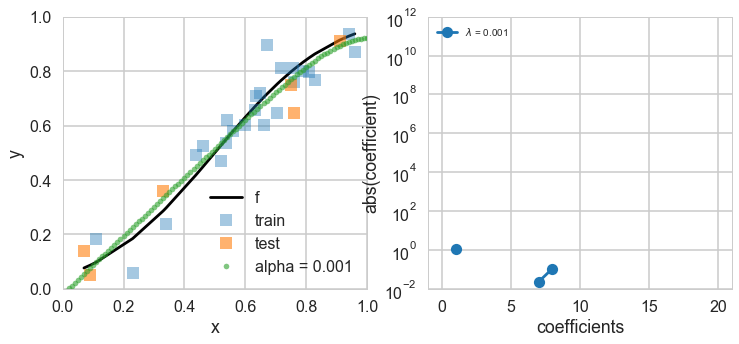

In [19]:
fig, rows = plt.subplots(1, 2, figsize=(12, 5))
l,r=rows
plot_functions_onall(clf, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(clf, r, alphawechoose)

As we can see, Lasso sets them exactly to 0

In [20]:
coef = clf.coef_.ravel()
coef

array([ 0.        ,  1.07256534,  0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.02227631, -0.10697882, -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ])